In [404]:
# author: netcan(https://github.com/netcan)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
%matplotlib inline

In [480]:
train_data = '../data/用例示例/TrainData_2015.12.txt'
test_data = '../data/用例示例/TestData_2016.1.8_2016.1.14.txt'
df = pd.read_csv(train_data, delimiter='\t', header=None, 
                names=['vm-id', 'vm-name', 'create_at'],
                parse_dates=['create_at'])
df_test = pd.read_csv(test_data, delimiter='\t', header=None, 
                names=['vm-id', 'vm-name', 'create_at'],
                parse_dates=['create_at'])
df = df.append(df_test)
df['create_date'] = df['create_at'].apply(lambda x: x.date())
predict_date = date(2016, 1, 8)

In [481]:
df.tail()

,vm-id,vm-name,create_at,create_date
184,56641995-8fc4,flavor2,2016-01-14 23:56:08,2016-01-14
185,56641996-91bc,flavor2,2016-01-14 23:56:12,2016-01-14
186,56641997-b60d,flavor2,2016-01-14 23:56:14,2016-01-14
187,56641998-ab6f,flavor2,2016-01-14 23:56:15,2016-01-14
188,56641999-8ab2,flavor2,2016-01-14 23:56:15,2016-01-14


In [482]:
interval = pd.date_range(df.create_date.min(), df.create_date.max()).tolist()

In [483]:
def get_flavors_complete(df):
    flavors_complete = {}
    interval = pd.date_range(df.create_date.min(), df.create_date.max()).tolist()
    for flavor in df['vm-name'].unique():
        f = df[df['vm-name'] == flavor].groupby('create_date')['vm-name'].count()
        for intval in interval:
            if intval.date() not in f:
                f = f.append(pd.Series({intval.date(): 0}))

        frame = f.to_frame().rename(columns={0: 'count'}).sort_index()
        frame['cumsum'] = frame['count'].cumsum()
        flavors_complete[flavor] = frame
    return flavors_complete
flavors_complete = get_flavors_complete(df) # 补齐日期，没有的补0个

In [484]:
predict_vm = [1, 2, 4, 5, 8]

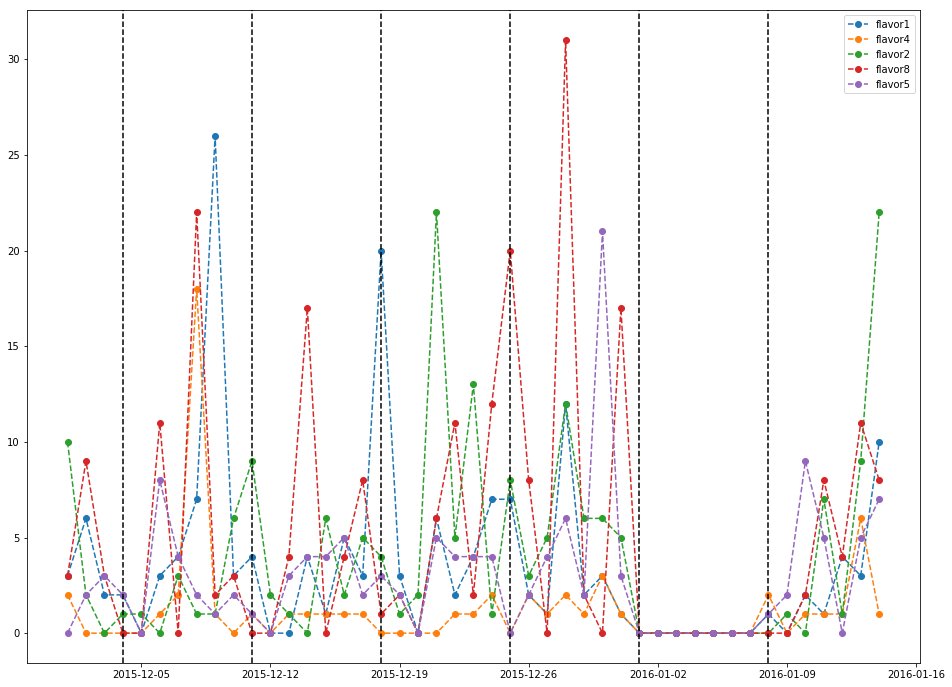

In [485]:
def plot_per_vm_count(flavors_complete):
    plt.figure(figsize=(16, 12))
    predict_date = date(2016, 1, 8)
    for vm_name, flavor in flavors_complete.items(): 
        if int(vm_name[6:]) in predict_vm:
            plt.plot(flavor.index, flavor['count'], 'o--', label=vm_name)

    start_date = predict_date
    while start_date in flavor.index:
        plt.axvline(x=start_date, color='k', linestyle='--')
        start_date -= timedelta(days=during_days)
    plt.legend()

plot_per_vm_count(flavors_complete)

In [491]:
flavors_complete['flavor8']

,count,cumsum
2015-12-01,3,3
2015-12-02,9,12
2015-12-03,3,15
2015-12-04,0,15
2015-12-05,0,15
2015-12-06,11,26
2015-12-07,0,26
2015-12-08,22,48
2015-12-09,2,50
2015-12-10,3,53


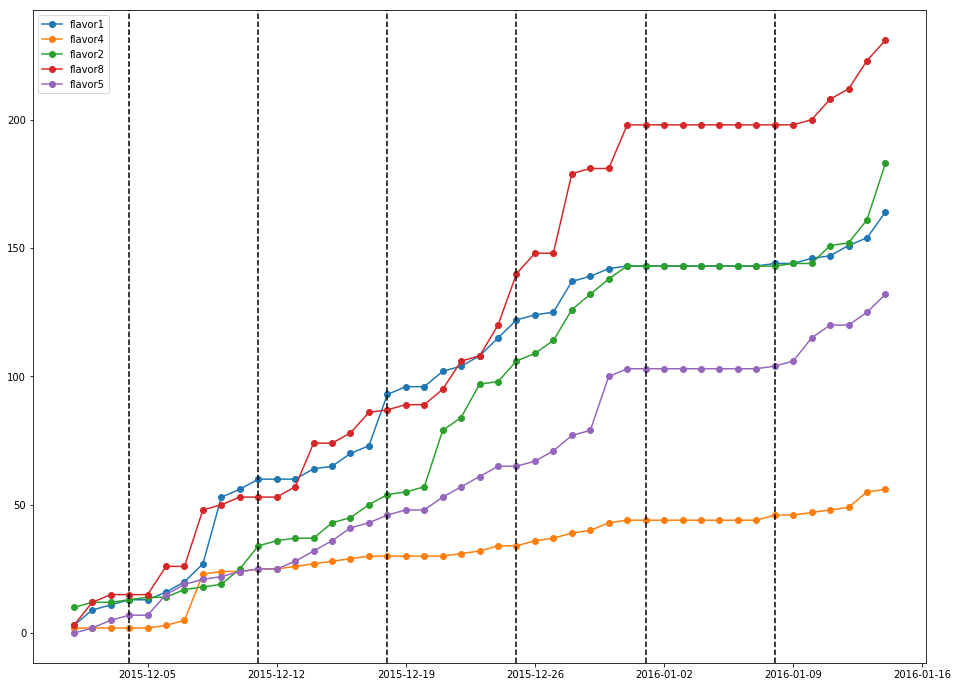

In [487]:
def plot_per_vm_cumsum(flavors_complete):
    plt.figure(figsize=(16, 12))
    for vm_name, flavor in flavors_complete.items():
        if int(vm_name[6:]) in predict_vm:
            plt.plot(flavor.index, flavor['cumsum'], 'o-', label=vm_name)

    start_date = predict_date
    while start_date in flavor.index:
        plt.axvline(x=start_date, color='k', linestyle='--')
        start_date -= timedelta(days=during_days)
    plt.legend()
plot_per_vm_cumsum(flavors_complete)

In [468]:
f15 = flavors_complete['flavor15']
f15.loc[date(2015, 1, 1):date(2015, 1, 8)]['count'].sum()

0

In [469]:
def getCount(vm_name, start_date, during_days):
    flavor = flavors_complete[vm_name]
    if start_date in flavor.index: 
        return flavor.loc[start_date:start_date + timedelta(days=during_days-1)]['count'].sum()
    return None

In [470]:
def shell_coefficient(y, Y):
    """y预测值， Y真实值"""
    return \
    np.sqrt(np.average( [(y[i] - Y[i])**2 for i in range(len(y))] )) / \
    ( np.sqrt(np.average( [y[i] ** 2 for i in range(len(y))] )) + np.sqrt(np.average( [Y[i] ** 2 for i in range(len(y))] )))

In [471]:
fmt = '{:>10}{:>10}{:>10}{:>10}'
print(fmt.format('vm-name', 'last7', 'next7', 'diff'))
for vm_name in flavors_complete:
    if int(vm_name[6:]) in predict_vm:
        last7 = getCount(vm_name, date(2015, 2, 13), 7)
        next7 = getCount(vm_name, date(2015, 2, 20), 7)
        print(fmt.format(vm_name, last7, next7, next7 - last7))

   vm-name     last7     next7      diff


TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

In [472]:
shell_coefficient(
    [getCount('flavor' + str(vm), date(2015, 2, 13), 7) for vm in predict_vm],
    [getCount('flavor' + str(vm), date(2015, 2, 20), 7) for vm in predict_vm]
)

TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

In [285]:
getCount('flavor1', date(2015, 2, 13), 7)

1

In [457]:
during_days = 7
flavors_intval_count = {}
for vm_name in flavors_complete:
    intval_count = {}
    start_date = predict_date
    count = getCount(vm_name, start_date, during_days)
    while count is not None:
        intval_count[start_date] = count
        start_date -= timedelta(days=during_days)
        count = getCount(vm_name, start_date, during_days)
    flavors_intval_count[vm_name] = pd.Series(intval_count)

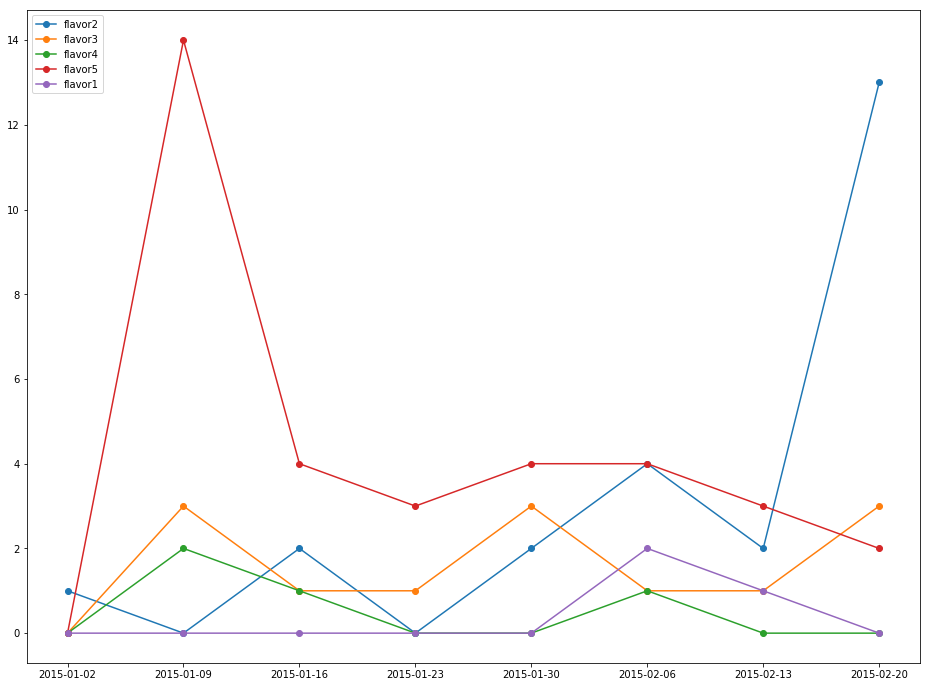

In [341]:
plt.figure(figsize=(16, 12))
for vm_name, flavor in flavors_intval_count.items():  
    if int(vm_name[6:]) in predict_vm:
        plt.plot(flavor, 'o-', label=vm_name)
plt.legend()

In [412]:
flavors_intval_count['flavor1']

2015-01-02    0
2015-01-09    0
2015-01-16    0
2015-01-23    0
2015-01-30    0
2015-02-06    2
2015-02-13    1
2015-02-20    0
dtype: int64

In [376]:
predict_date

datetime.date(2015, 2, 20)

In [424]:
combine_data = '../data/练习数据/combine_data_2015_1-5.txt'
cmb_df = pd.read_csv(combine_data, delimiter='\t', header=None, 
                names=['vm-id', 'vm-name', 'create_at'],
                parse_dates=['create_at'])
cmb_df['create_date'] = cmb_df['create_at'].apply(lambda x: x.date())

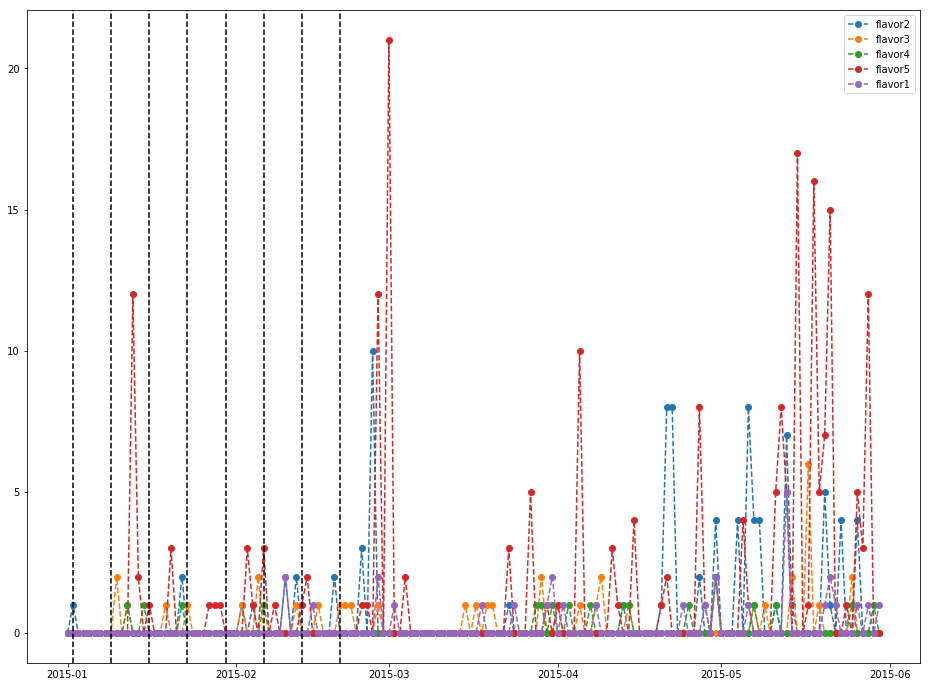

In [458]:
cmb_flavors_complete = get_flavors_complete(cmb_df)
plot_per_vm_count(cmb_flavors_complete)

In [460]:
cmb_flavors_complete['flavor1']

,count,cumsum
2015-01-01,0,0
2015-01-02,0,0
2015-01-03,0,0
2015-01-04,0,0
2015-01-05,0,0
2015-01-06,0,0
2015-01-07,0,0
2015-01-08,0,0
2015-01-09,0,0
2015-01-10,0,0


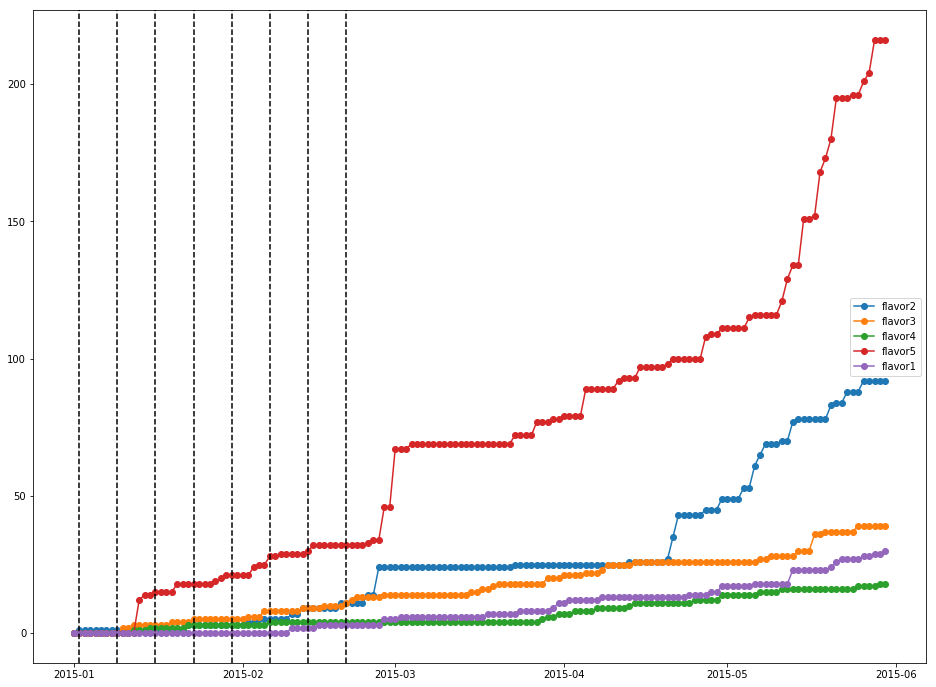

In [431]:
plot_per_vm_cumsum(cmb_flavors_complete)

In [450]:
a = [10] * 10
b = [1] * 10
1 - shell_coefficient(a, b)

0.18181818181818177

In [506]:
r = [21, 40, 12, 29, 33]
p = [42, 70, 11, 29, 50]

In [507]:
1 - shell_coefficient(r, p)

0.7549062421878856

In [508]:
_ * 0.906

0.68394505542222439

In [516]:
((23/25 + 28/30)/2 + (23/25 + 25/30)/2)/2

0.9016666666666667

In [518]:
(46/50 + 53/60) /2

0.9016666666666666

In [520]:
a = 4
b = 5
c = 8
d = 9

In [521]:
(b/a+d/c)/2

1.1875

In [522]:
(b+d)/(a+c)

1.1666666666666667